# Week 4: LogSumExp Continuation for Minimizing Peak Autoconvolution

## Problem Statement

We seek the constant $C_{1a}$, defined as:

$$C_{1a} = \inf_{f} \frac{\|f * f\|_\infty}{\|f\|_1^2}$$

where the infimum is taken over nonnegative $f \in L^1[-1/4, 1/4]$.

**In plain terms:** Given a nonnegative function $f$ supported on $[-1/4, 1/4]$ with $\int f = 1$, we want to minimize the peak value of its autoconvolution $(f * f)(t) = \int f(x) f(t - x) \, dx$.

### Mathematical Formulation

We discretize $f$ as a **step function** on $P$ equal-width bins over $[-1/4, 1/4]$:

- **Decision variable:** $x \in \Delta^{P-1}$ (probability simplex), where $x_i$ is the mass in bin $i$
- **Heights:** $h_i = x_i / \Delta$ where $\Delta = 1/(2P)$ is the bin width
- **Autoconvolution coefficients:** $c_k = 2P \sum_{i+j=k} x_i x_j$ (the discrete autoconvolution scaled by $2P$)
- **Objective:** $\min_{x \in \Delta^{P-1}} \max_k c_k$

### Key Challenge

The objective $\max_k c_k$ is **non-smooth and non-convex** (it is the supremum of quadratic forms). Gradient methods suffer from **peak-locking**: the gradient only sees the current argmax location, trapping the optimizer.

### Our Approach: LogSumExp Continuation

Replace the non-smooth $\max$ with a smooth surrogate:

$$\text{LSE}_\beta(c) = \frac{1}{\beta} \log \sum_k \exp(\beta \, c_k)$$

**Properties:**
- $\max_k c_k \leq \text{LSE}_\beta(c) \leq \max_k c_k + \frac{\log n}{\beta}$
- Gradient: $\nabla_{c_k} \text{LSE}_\beta = \text{softmax}(\beta \, c)_k$ distributes gradient across near-peak positions
- Start with small $\beta$ (smooth landscape), gradually increase toward the true $\max$

### Success Metrics

The current best upper bound is $1.5029$, achieved by researchers at Stanford University, Nvidia, and Together AI. The dream goal is to reduce this upper bound and hence produce a new tightest bound. A more realistic goal is to beat Professor Davis's best upper bound ($1.50972$)

---
## 1. Setup and Imports

In [1]:
import os
import time
import json

import numpy as np
import numba as nb
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

print(f"Numba {nb.__version__}, NumPy {np.__version__}")
print(f"CPU cores available: {os.cpu_count()}")

Numba 0.63.1, NumPy 2.3.5
CPU cores available: 16


---
## 2. Objective Function Implementation

### 2a. Exact Peak Autoconvolution

For a step function $f$ with given edges and heights, $(f*f)(t)$ is piecewise-linear with breakpoints at $t = e_i + e_j$. The maximum must occur at one of these $O(P^2)$ breakpoints, so we evaluate all of them to get the exact peak.

In [2]:
def peak_autoconv_exact(edges, heights):
    """
    Compute the exact peak of (f*f)(t) for a step function f.
    
    f(x) = heights[i] for edges[i] <= x < edges[i+1], zero outside.
    (f*f)(t) = integral f(x) f(t-x) dx
    
    Returns (peak_value, peak_location).
    """
    edges = np.asarray(edges, dtype=np.float64)
    heights = np.asarray(heights, dtype=np.float64)
    N = len(heights)

    # All breakpoints where (f*f)(t) can change slope
    bp = (edges[:, None] + edges[None, :]).ravel()
    bp = np.unique(bp)
    bp = bp[(bp >= 2 * edges[0]) & (bp <= 2 * edges[-1])]

    a = edges[:-1]  # left edges of bins
    b = edges[1:]   # right edges of bins

    peak = -np.inf
    peak_t = None

    # Process breakpoints in batches for memory efficiency
    batch_size = 500
    for start in range(0, len(bp), batch_size):
        end = min(start + batch_size, len(bp))
        t_batch = bp[start:end]

        # For each bin pair (i,j), the overlap integral contributes:
        # h_i * h_j * max(0, min(b_i, t - a_j) - max(a_i, t - b_j))
        conv = np.zeros(len(t_batch))
        for i in range(N):
            for j in range(N):
                lo = np.maximum(a[i], t_batch - b[j])
                hi = np.minimum(b[i], t_batch - a[j])
                overlap = np.maximum(0.0, hi - lo)
                conv += heights[i] * heights[j] * overlap

        idx = np.argmax(conv)
        if conv[idx] > peak:
            peak = conv[idx]
            peak_t = t_batch[idx]

    return float(peak), float(peak_t)


def exact_val(x, P):
    """Compute exact peak autoconvolution from simplex weights x with P bins."""
    edges = np.linspace(-0.25, 0.25, P + 1)
    bin_width = 0.5 / P
    heights = x / bin_width
    peak, _ = peak_autoconv_exact(edges, heights)
    return peak

### 2b. Core Numba-JIT Functions

All inner-loop math is compiled to machine code via Numba for ~50-100x speedup. These are the building blocks:

- **Simplex projection** (Duchi et al., 2008): project any vector onto $\Delta^{P-1}$
- **Autoconvolution coefficients:** $c_k = 2P \sum_{i+j=k} x_i x_j$
- **LogSumExp and softmax:** smooth approximation to $\max$ and its gradient weights
- **LSE objective and gradient:** full objective $\text{LSE}_\beta(c(x))$ and $\nabla_x$
- **Armijo line search:** adaptive step size via backtracking

In [3]:
@nb.njit(cache=True)
def project_simplex_nb(x):
    """Project x onto the probability simplex (Duchi et al., 2008)."""
    n = len(x)
    u = np.sort(x)[::-1]
    cssv = np.cumsum(u) - 1.0
    rho = 0
    for i in range(n):
        if u[i] * (i + 1) > cssv[i]:
            rho = i
    tau = cssv[rho] / (rho + 1.0)
    out = np.empty(n)
    for i in range(n):
        out[i] = max(x[i] - tau, 0.0)
    return out


@nb.njit(cache=True)
def convolve_full(a, b):
    """Full convolution of two 1D arrays."""
    na, nb_ = len(a), len(b)
    nc = na + nb_ - 1
    c = np.zeros(nc)
    for i in range(na):
        for j in range(nb_):
            c[i + j] += a[i] * b[j]
    return c


@nb.njit(cache=True)
def autoconv_coeffs(x, P):
    """Compute autoconvolution coefficients: c_k = 2P * sum_{i+j=k} x_i x_j."""
    return convolve_full(x, x) * (2.0 * P)


@nb.njit(cache=True)
def logsumexp_nb(c, beta):
    """Numerically stable LogSumExp: (1/beta) * log(sum(exp(beta * c_k)))."""
    bc_max = -1e300
    for i in range(len(c)):
        v = beta * c[i]
        if v > bc_max:
            bc_max = v
    s = 0.0
    for i in range(len(c)):
        s += np.exp(beta * c[i] - bc_max)
    return bc_max / beta + np.log(s) / beta


@nb.njit(cache=True)
def softmax_nb(c, beta):
    """Softmax weights: exp(beta * c_k) / sum(exp(beta * c_j))."""
    n = len(c)
    bc_max = -1e300
    for i in range(n):
        v = beta * c[i]
        if v > bc_max:
            bc_max = v
    e = np.empty(n)
    s = 0.0
    for i in range(n):
        e[i] = np.exp(beta * c[i] - bc_max)
        s += e[i]
    for i in range(n):
        e[i] /= s
    return e


@nb.njit(cache=True)
def lse_obj_nb(x, P, beta):
    """LSE objective: LSE_beta(autoconv_coeffs(x))."""
    c = autoconv_coeffs(x, P)
    return logsumexp_nb(c, beta)


@nb.njit(cache=True)
def lse_grad_nb(x, P, beta):
    """Gradient of LSE_beta(c(x)) w.r.t. x.
    
    Using chain rule: g_i = 2*(2P) * sum_k w_k * x_{k-i}
    where w = softmax(beta * c).
    """
    c = autoconv_coeffs(x, P)
    w = softmax_nb(c, beta)
    n = len(x)
    n_c = len(c)
    g = np.zeros(n)
    for i in range(n):
        s = 0.0
        for k in range(n_c):
            j = k - i
            if 0 <= j < n:
                s += w[k] * x[j]
        g[i] = s
    scale = 2.0 * (2.0 * P)
    for i in range(n):
        g[i] *= scale
    return g


@nb.njit(cache=True)
def armijo_step_nb(x, g, P, beta, alpha_init, rho=0.5, c1=1e-4, max_bt=30):
    """Armijo backtracking line search on the projected gradient step."""
    fval = lse_obj_nb(x, P, beta)
    alpha = alpha_init
    x_new = np.empty_like(x)
    for _ in range(max_bt):
        for i in range(len(x)):
            x_new[i] = x[i] - alpha * g[i]
        x_new = project_simplex_nb(x_new)
        fval_new = lse_obj_nb(x_new, P, beta)
        descent = 0.0
        for i in range(len(x)):
            descent += g[i] * (x[i] - x_new[i])
        if fval_new <= fval - c1 * descent:
            return x_new, fval_new, alpha
        alpha *= rho
    return x_new, fval_new, alpha


# Warm up JIT compilation (first call compiles; subsequent calls are fast)
_x_warmup = np.ones(5) / 5.0
_ = project_simplex_nb(_x_warmup)
_ = autoconv_coeffs(_x_warmup, 5)
_ = lse_obj_nb(_x_warmup, 5, 10.0)
_ = lse_grad_nb(_x_warmup, 5, 10.0)
_ = armijo_step_nb(_x_warmup, np.ones(5), 5, 10.0, 0.1)
print("JIT compilation complete.")

JIT compilation complete.


### Gradient Verification

Sanity check: compare the analytical JIT gradient against finite differences.

In [4]:
np.random.seed(42)
P_test = 10
x_test = np.random.dirichlet(np.ones(P_test))
beta_test = 10.0

g_jit = lse_grad_nb(x_test, P_test, beta_test)

eps = 1e-7
g_fd = np.zeros(P_test)
for i in range(P_test):
    x_p = x_test.copy(); x_p[i] += eps
    x_m = x_test.copy(); x_m[i] -= eps
    g_fd[i] = (lse_obj_nb(x_p, P_test, beta_test) - lse_obj_nb(x_m, P_test, beta_test)) / (2 * eps)

max_err = np.max(np.abs(g_jit - g_fd))
print(f"JIT gradient vs finite diff: max error = {max_err:.2e}")
assert max_err < 1e-4, f"Gradient check failed: error = {max_err}"
print("Gradient verification PASSED.")

JIT gradient vs finite diff: max error = 2.00e-09
Gradient verification PASSED.


---
## 3. Optimization Algorithm

### 3a. LSE Nesterov Optimizer (Phase 1: Basin-Finding)

Uses Nesterov accelerated gradient descent with Armijo line search on the smooth LSE surrogate. A **beta-continuation schedule** gradually sharpens the approximation from smooth ($\beta$ small) to near-exact ($\beta$ large).

**Key parameters:**
- `beta_schedule`: Sequence of increasing $\beta$ values. Finer schedules help avoid getting trapped.
- `n_iters_per_beta`: Max iterations at each $\beta$ stage (early stopping on stagnation).
- `n_restarts`: Number of random initializations (parallelized across CPU cores).

In [5]:
@nb.njit(cache=True)
def _lse_nesterov(x_init, P, beta_schedule, n_iters_per_beta):
    """Single LSE Nesterov continuation run. Returns (best_true_max, best_x)."""
    x = x_init.copy()
    best_val = 1e300
    best_x = x.copy()

    for stage in range(len(beta_schedule)):
        beta = beta_schedule[stage]
        y = x.copy()
        x_prev = x.copy()
        alpha_init = 0.1
        best_stage_val = 1e300
        best_stage_x = x.copy()
        no_improve = 0

        for t in range(n_iters_per_beta):
            g = lse_grad_nb(y, P, beta)
            x_new, fval_new, alpha_used = armijo_step_nb(y, g, P, beta, alpha_init)
            alpha_init = min(alpha_used * 2.0, 1.0)

            # Nesterov momentum: y = x_new + momentum * (x_new - x_prev)
            momentum = t / (t + 3.0)
            n = len(x_new)
            y_new = np.empty(n)
            for i in range(n):
                y_new[i] = x_new[i] + momentum * (x_new[i] - x_prev[i])
            y_new = project_simplex_nb(y_new)

            x_prev = x_new.copy()
            x = x_new
            y = y_new

            # Track true (non-smooth) objective for this stage
            true_val = np.max(autoconv_coeffs(x, P))
            if true_val < best_stage_val:
                best_stage_val = true_val
                best_stage_x = x.copy()
                no_improve = 0
            else:
                no_improve += 1

            # Early stopping if stagnant
            if no_improve > 1000:
                break

        x = best_stage_x

    true_val = np.max(autoconv_coeffs(x, P))
    if true_val < best_val:
        best_val = true_val
        best_x = x.copy()

    return best_val, best_x


# Warm up
_bs = np.array([1.0, 10.0, 100.0])
_ = _lse_nesterov(np.ones(5) / 5.0, 5, _bs, 10)
print("LSE Nesterov optimizer compiled.")

LSE Nesterov optimizer compiled.


### 3b. Polyak Subgradient Polish (Phase 2: Local Refinement)

After finding a good basin with LSE, we polish using the **Polyak subgradient method** on the true (non-smooth) $\max_k c_k$ objective. The step size is:

$$\alpha_t = \frac{f(x_t) - f^*_{\text{target}}}{\|g_t\|^2}$$

where $f^*_{\text{target}}$ is an adaptive target that shrinks as we improve.

In [6]:
@nb.njit(cache=True)
def _polyak_polish(x_init, P, n_iters):
    """Adaptive Polyak polish: target = best_val - shrinking_offset."""
    x = x_init.copy()
    n = len(x)
    best_val = np.max(autoconv_coeffs(x, P))
    best_x = x.copy()

    for t in range(n_iters):
        c = autoconv_coeffs(x, P)
        fval = np.max(c)
        if fval < best_val:
            best_val = fval
            best_x = x.copy()

        # Adaptive target: shrinks offset over time to fine-tune
        offset = 0.01 / (1.0 + t * 1e-4)
        target = best_val - offset

        # Find argmax for subgradient
        k_star = 0
        for k in range(len(c)):
            if c[k] > c[k_star]:
                k_star = k

        # Subgradient of max_k c_k at the argmax
        g = np.zeros(n)
        for i in range(n):
            j = k_star - i
            if 0 <= j < n:
                g[i] = 2.0 * (2.0 * P) * x[j]

        gnorm2 = 0.0
        for i in range(n):
            gnorm2 += g[i] * g[i]
        if gnorm2 < 1e-20:
            break

        # Polyak step size
        step = (fval - target) / gnorm2
        if step < 0.0:
            step = 1e-5 / (1.0 + t * 1e-4)

        for i in range(n):
            x[i] = x[i] - step * g[i]
        x = project_simplex_nb(x)

    return best_val, best_x


# Warm up
_ = _polyak_polish(np.ones(5) / 5.0, 5, 10)
print("Polyak polish compiled.")

Polyak polish compiled.


### 3c. Hybrid Optimizer (LSE + Polyak)

The two-phase **hybrid** approach:
1. **Phase 1 (LSE Nesterov):** Smooth beta-continuation finds a good basin
2. **Phase 2 (Polyak polish):** Non-smooth subgradient refines within that basin

Multiple random restarts are run **in parallel** across CPU cores.

In [7]:
@nb.njit(cache=True)
def _hybrid_single(x_init, P, beta_schedule, n_iters_lse, n_iters_polyak):
    """One hybrid restart: LSE continuation -> Polyak polish."""
    # Phase 1: LSE Nesterov continuation
    lse_val, x_lse = _lse_nesterov(x_init, P, beta_schedule, n_iters_lse)

    # Phase 2: Polyak polish starting from LSE solution
    polished_val, polished_x = _polyak_polish(x_lse, P, n_iters_polyak)

    return lse_val, polished_val, polished_x


# Warm up
_bs = np.array([1.0, 10.0])
_ = _hybrid_single(np.ones(5) / 5.0, 5, _bs, 10, 10)


def optimize_hybrid(P, beta_schedule, n_iters_lse=10000, n_iters_polyak=100000,
                    n_restarts=30, n_jobs=-1):
    """Run hybrid optimizer with parallel random restarts.
    
    Args:
        P: Number of bins in the step function discretization.
        beta_schedule: List of increasing beta values for LSE continuation.
        n_iters_lse: Max iterations per beta stage in Phase 1.
        n_iters_polyak: Iterations for Polyak polish in Phase 2.
        n_restarts: Number of independent random initializations.
        n_jobs: Number of parallel workers (-1 = all cores).
    
    Returns:
        (best_value, best_x, all_results) where all_results is a list of 
        (lse_val, polished_val) for each restart.
    """
    beta_arr = np.array(beta_schedule, dtype=np.float64)
    rng = np.random.default_rng()
    inits = [rng.dirichlet(np.ones(P)) for _ in range(n_restarts)]

    results = Parallel(n_jobs=n_jobs, verbose=0)(
        delayed(_hybrid_single)(inits[i], P, beta_arr, n_iters_lse, n_iters_polyak)
        for i in range(n_restarts)
    )

    best_val = np.inf
    best_x = None
    all_results = []
    for lse_v, pol_v, x in results:
        all_results.append((lse_v, pol_v))
        if pol_v < best_val:
            best_val = pol_v
            best_x = x.copy()

    return best_val, best_x, all_results


print("Hybrid optimizer defined.")

Hybrid optimizer defined.


### Key Parameters

The beta schedule is the most important hyperparameter. It controls the continuation path from smooth to sharp:

- **Too aggressive** (few large jumps): optimizer gets trapped in bad basins
- **Too gentle** (many tiny steps): wastes compute in overly-smooth regimes
- **Our choice:** 15-stage geometric-ish schedule from 1 to 2000

In [8]:
# Default beta schedule used throughout this notebook
BETA_SCHEDULE = [1, 2, 4, 8, 15, 30, 60, 100, 150, 250, 400, 600, 1000, 1500, 2000]

print(f"Beta schedule ({len(BETA_SCHEDULE)} stages): {BETA_SCHEDULE}")
print(f"Ratio between consecutive stages: ", end="")
ratios = [BETA_SCHEDULE[i+1]/BETA_SCHEDULE[i] for i in range(len(BETA_SCHEDULE)-1)]
print(f"min={min(ratios):.2f}, max={max(ratios):.2f}, mean={np.mean(ratios):.2f}")

Beta schedule (15 stages): [1, 2, 4, 8, 15, 30, 60, 100, 150, 250, 400, 600, 1000, 1500, 2000]
Ratio between consecutive stages: min=1.33, max=2.00, mean=1.74


---
## 4. Run Optimization

Run the hybrid optimizer across multiple discretization levels $P$ and log results.

In [9]:
P_VALUES = [50, 100, 200, 500]

results = {}
total_start = time.time()

for P in P_VALUES:
    print(f"\n{'='*60}")
    print(f"P = {P} ({P} bins, {2*P-1} autoconvolution coefficients)")
    print(f"{'='*60}")

    t0 = time.time()
    val, x, all_res = optimize_hybrid(
        P, BETA_SCHEDULE,
        n_iters_lse=10000,
        n_iters_polyak=100000,
        n_restarts=30
    )
    dt = time.time() - t0

    # Exact verification
    ev = exact_val(x, P)

    # Log restart statistics
    polished_vals = [r[1] for r in all_res]
    lse_vals = [r[0] for r in all_res]

    print(f"  Time: {dt:.1f}s")
    print(f"  Exact peak: {ev:.6f}")
    print(f"  Restart stats (polished): min={min(polished_vals):.6f}, "
          f"median={np.median(polished_vals):.6f}, std={np.std(polished_vals):.6f}")
    print(f"  LSE->Polyak improvement: {np.mean(lse_vals) - np.mean(polished_vals):.6f} avg")

    results[P] = {
        'exact_peak': ev,
        'simplex_weights': x,
        'time_s': dt,
        'all_polished': polished_vals,
    }

total_time = time.time() - total_start
print(f"\nTotal optimization time: {total_time:.1f}s ({total_time/60:.1f} min)")


P = 50 (50 bins, 99 autoconvolution coefficients)


  Time: 22.2s
  Exact peak: 1.519650
  Restart stats (polished): min=1.519650, median=1.527014, std=0.003095
  LSE->Polyak improvement: 0.000456 avg

P = 100 (100 bins, 199 autoconvolution coefficients)
  Time: 7.0s
  Exact peak: 1.514982
  Restart stats (polished): min=1.514982, median=1.520508, std=0.003565
  LSE->Polyak improvement: 0.000262 avg

P = 200 (200 bins, 399 autoconvolution coefficients)
  Time: 19.1s
  Exact peak: 1.510295
  Restart stats (polished): min=1.510295, median=1.516688, std=0.002677
  LSE->Polyak improvement: 0.001011 avg

P = 500 (500 bins, 999 autoconvolution coefficients)
  Time: 101.8s
  Exact peak: 1.508613
  Restart stats (polished): min=1.508613, median=1.514581, std=0.003700
  LSE->Polyak improvement: 0.000514 avg

Total optimization time: 160.5s (2.7 min)


### Results Summary

In [10]:
print(f"{'P':>6} | {'Peak autoconv':>14} | {'Time (s)':>10} | {'Literature':>12}")
print('-' * 55)
for P in P_VALUES:
    r = results[P]
    print(f"{P:>6} | {r['exact_peak']:>14.6f} | {r['time_s']:>10.1f} | {1.5029:>12.4f}")

best_P = min(results, key=lambda p: results[p]['exact_peak'])
best_val = results[best_P]['exact_peak']
print(f"\nBest result: {best_val:.6f} at P={best_P}")
print(f"Gap to literature best (1.5029): {best_val - 1.5029:+.4f}")

     P |  Peak autoconv |   Time (s) |   Literature
-------------------------------------------------------
    50 |       1.519650 |       22.2 |       1.5029
   100 |       1.514982 |        7.0 |       1.5029
   200 |       1.510295 |       19.1 |       1.5029
   500 |       1.508613 |      101.8 |       1.5029

Best result: 1.508613 at P=500
Gap to literature best (1.5029): +0.0057


---
## 5. Validation

### 5a. Test Cases: Known Analytical Results

In [11]:
print("Test 1: Uniform distribution f(x) = 2 on [-1/4, 1/4]")
print("  Expected: peak autoconv = 2.0 at t = 0")
test_edges = np.linspace(-0.25, 0.25, 101)
test_heights = np.ones(100) * 2.0  # f = 2 on [-0.25, 0.25], integral = 1
peak, peak_t = peak_autoconv_exact(test_edges, test_heights)
print(f"  Got: peak = {peak:.6f} at t = {peak_t:.4f}")
assert abs(peak - 2.0) < 1e-4, f"Expected ~2.0, got {peak}"
print("  PASSED\n")

print("Test 2: Concentrated on single bin (Dirac-like)")
print("  Expected: peak autoconv = 2P (maximizes the peak)")
P_t = 50
x_dirac = np.zeros(P_t)
x_dirac[P_t // 2] = 1.0  # all mass in center bin
peak_dirac = exact_val(x_dirac, P_t)
print(f"  Got: peak = {peak_dirac:.2f} (expected ~{2*P_t})")
assert abs(peak_dirac - 2*P_t) < 1.0, f"Expected ~{2*P_t}, got {peak_dirac}"
print("  PASSED\n")

print("Test 3: Simplex constraint is maintained during optimization")
for P in P_VALUES:
    x = results[P]['simplex_weights']
    assert abs(x.sum() - 1.0) < 1e-10, f"P={P}: sum = {x.sum()}"
    assert np.all(x >= -1e-15), f"P={P}: has negative weights"
print(f"  All {len(P_VALUES)} solutions satisfy simplex constraints.")
print("  PASSED\n")

print("Test 4: Exact evaluation matches fast evaluation")
for P in P_VALUES:
    x = results[P]['simplex_weights']
    fast_val = np.max(autoconv_coeffs(x, P))
    exact = results[P]['exact_peak']
    rel_err = abs(fast_val - exact) / exact
    print(f"  P={P}: fast={fast_val:.6f}, exact={exact:.6f}, rel_err={rel_err:.2e}")
    assert rel_err < 0.01, f"P={P}: fast and exact differ by {rel_err:.2e}"
print("  PASSED")

Test 1: Uniform distribution f(x) = 2 on [-1/4, 1/4]
  Expected: peak autoconv = 2.0 at t = 0
  Got: peak = 2.000000 at t = -0.0000
  PASSED

Test 2: Concentrated on single bin (Dirac-like)
  Expected: peak autoconv = 2P (maximizes the peak)
  Got: peak = 100.00 (expected ~100)
  PASSED

Test 3: Simplex constraint is maintained during optimization
  All 4 solutions satisfy simplex constraints.
  PASSED

Test 4: Exact evaluation matches fast evaluation
  P=50: fast=1.519650, exact=1.519650, rel_err=4.38e-16
  P=100: fast=1.514982, exact=1.514982, rel_err=2.93e-16
  P=200: fast=1.510295, exact=1.510295, rel_err=1.47e-16
  P=500: fast=1.508613, exact=1.508613, rel_err=1.91e-15
  PASSED


### 5b. Performance Measurements

In [12]:
import tracemalloc

print("Performance benchmarks:\n")

# Time individual operations
for P in [50, 200, 500]:
    x = np.random.dirichlet(np.ones(P))
    beta = 100.0

    # Autoconvolution
    t0 = time.time()
    for _ in range(1000):
        autoconv_coeffs(x, P)
    dt_autoconv = (time.time() - t0) / 1000 * 1e6

    # LSE gradient
    t0 = time.time()
    for _ in range(1000):
        lse_grad_nb(x, P, beta)
    dt_grad = (time.time() - t0) / 1000 * 1e6

    # Exact evaluation
    t0 = time.time()
    exact_val(x, P)
    dt_exact = (time.time() - t0) * 1e3

    print(f"P={P:>4}: autoconv={dt_autoconv:>8.1f}us, grad={dt_grad:>8.1f}us, exact_eval={dt_exact:>8.1f}ms")

# Memory usage for a full run
print("\nMemory usage for single hybrid restart (P=200):")
tracemalloc.start()
beta_arr = np.array(BETA_SCHEDULE, dtype=np.float64)
x_init = np.random.dirichlet(np.ones(200))
_ = _hybrid_single(x_init, 200, beta_arr, 1000, 10000)
current, peak_mem = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"  Current: {current / 1024:.1f} KB, Peak: {peak_mem / 1024:.1f} KB")

Performance benchmarks:

P=  50: autoconv=     1.6us, grad=     6.7us, exact_eval=    17.0ms
P= 200: autoconv=     6.0us, grad=    75.0us, exact_eval=   648.6ms
P= 500: autoconv=    36.0us, grad=   514.6us, exact_eval=  9812.5ms

Memory usage for single hybrid restart (P=200):
  Current: 4.9 KB, Peak: 22.7 KB


### 5c. Edge Cases

In [13]:
print("Edge case 1: Very small P (P=3)")
val_3, x_3, _ = optimize_hybrid(3, BETA_SCHEDULE, n_iters_lse=5000,
                                 n_iters_polyak=50000, n_restarts=10)
print(f"  P=3: peak = {val_3:.6f}, weights = {x_3}\n")

print("Edge case 2: Large beta (numerical stability)")
x_test = np.random.dirichlet(np.ones(50))
for beta in [1e2, 1e3, 1e4, 1e5]:
    val = lse_obj_nb(x_test, 50, beta)
    true_max = np.max(autoconv_coeffs(x_test, 50))
    print(f"  beta={beta:.0e}: LSE={val:.6f}, true_max={true_max:.6f}, gap={val-true_max:.2e}")
print()

print("Edge case 3: Nearly-uniform initialization")
x_uniform = np.ones(100) / 100
val_u = np.max(autoconv_coeffs(x_uniform, 100))
print(f"  Uniform x: peak = {val_u:.6f} (should be ~2.0)")
# Optimize starting from uniform
beta_arr = np.array(BETA_SCHEDULE, dtype=np.float64)
_, opt_val, opt_x = _hybrid_single(x_uniform, 100, beta_arr, 10000, 100000)
print(f"  After optimization: peak = {opt_val:.6f}")

Edge case 1: Very small P (P=3)
  P=3: peak = 1.706699, weights = [0.5333147  0.26667994 0.20000536]

Edge case 2: Large beta (numerical stability)
  beta=1e+02: LSE=2.249730, true_max=2.249711, gap=1.91e-05
  beta=1e+03: LSE=2.249711, true_max=2.249711, gap=0.00e+00
  beta=1e+04: LSE=2.249711, true_max=2.249711, gap=0.00e+00
  beta=1e+05: LSE=2.249711, true_max=2.249711, gap=0.00e+00

Edge case 3: Nearly-uniform initialization
  Uniform x: peak = 2.000000 (should be ~2.0)
  After optimization: peak = 1.525223


---
## 6. Visualization

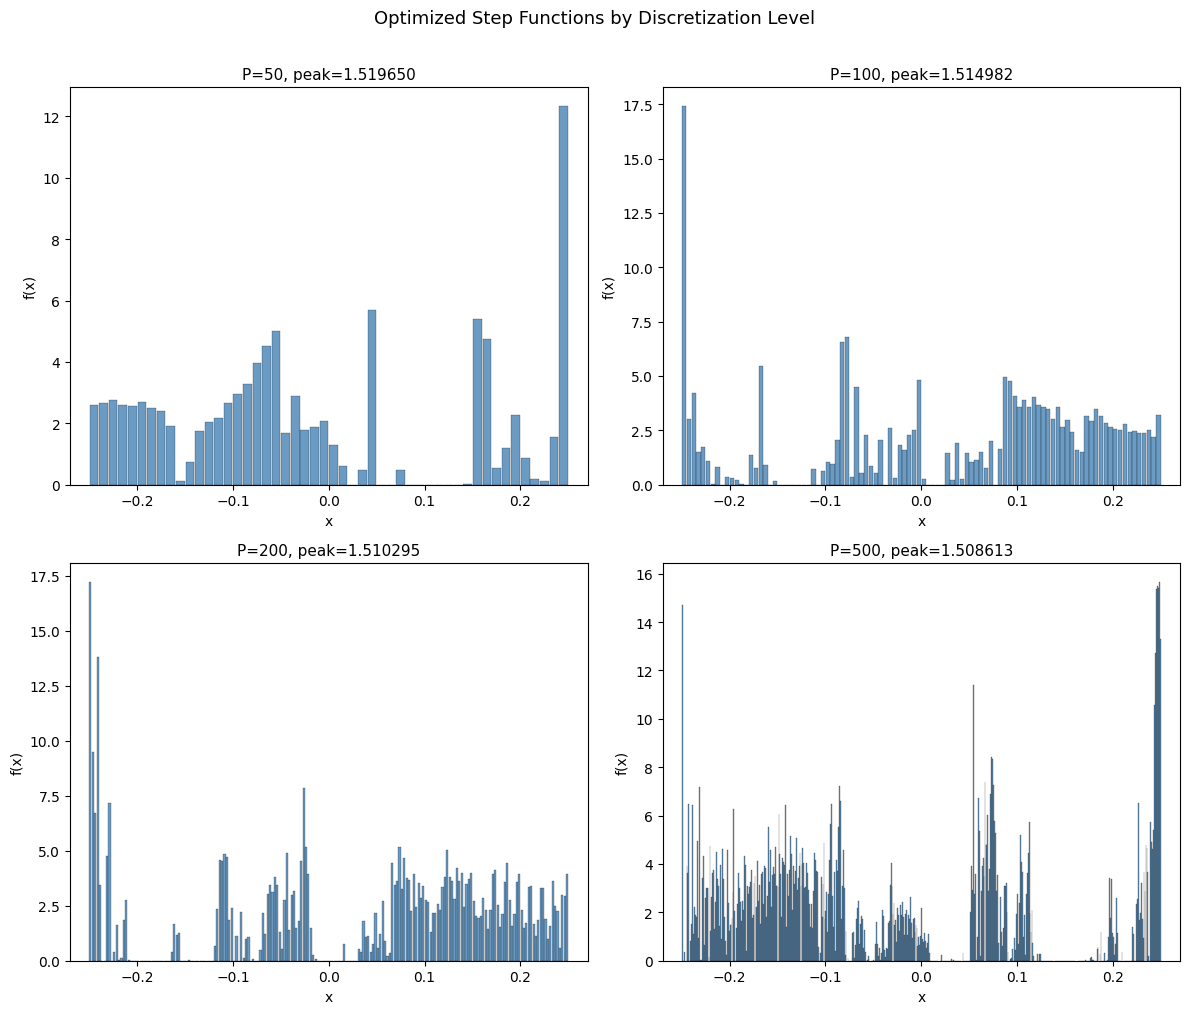

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, P in enumerate(P_VALUES):
    ax = axes[idx // 2, idx % 2]
    x = results[P]['simplex_weights']
    edges = np.linspace(-0.25, 0.25, P + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    bin_width = 0.5 / P

    ax.bar(centers, x / bin_width, width=bin_width * 0.9,
           color='steelblue', edgecolor='k', linewidth=0.2, alpha=0.8)
    ax.set_title(f'P={P}, peak={results[P]["exact_peak"]:.6f}', fontsize=11)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_xlim(-0.27, 0.27)

plt.suptitle('Optimized Step Functions by Discretization Level', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

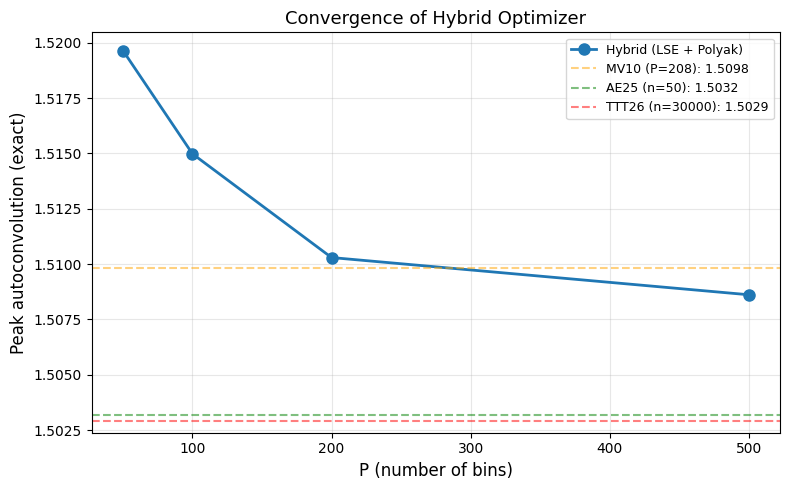

In [15]:
# Convergence plot: peak autoconvolution vs P
fig, ax = plt.subplots(figsize=(8, 5))

Ps = sorted(results.keys())
vals = [results[P]['exact_peak'] for P in Ps]

ax.plot(Ps, vals, 'o-', markersize=8, linewidth=2, label='Hybrid (LSE + Polyak)')
ax.axhline(1.5098, color='orange', linestyle='--', alpha=0.5, label='MV10 (P=208): 1.5098')
ax.axhline(1.5032, color='green', linestyle='--', alpha=0.5, label='AE25 (n=50): 1.5032')
ax.axhline(1.5029, color='red', linestyle='--', alpha=0.5, label='TTT26 (n=30000): 1.5029')

ax.set_xlabel('P (number of bins)', fontsize=12)
ax.set_ylabel('Peak autoconvolution (exact)', fontsize=12)
ax.set_title('Convergence of Hybrid Optimizer', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

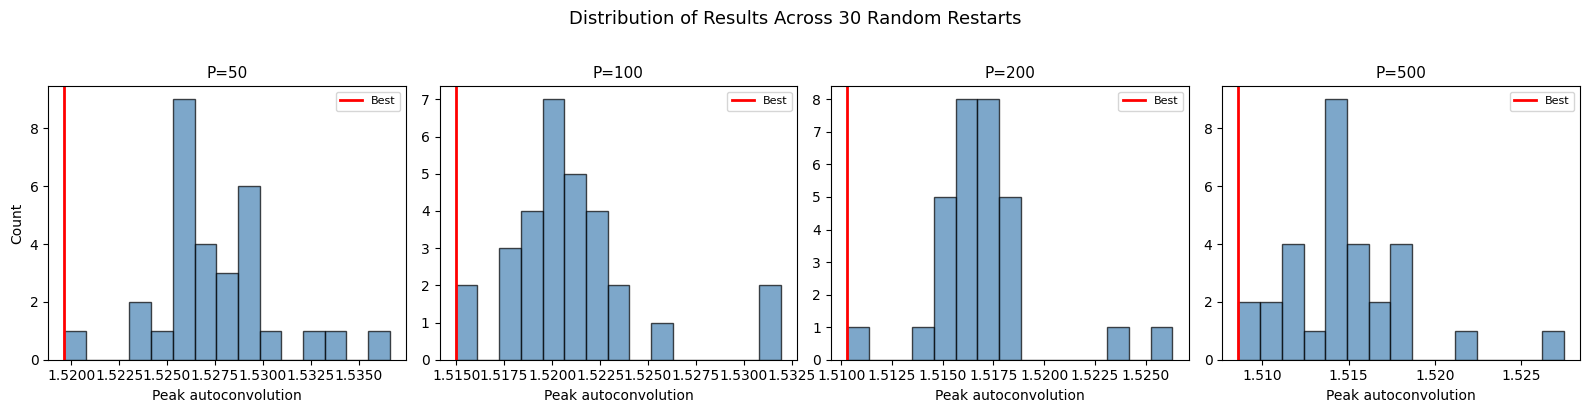

In [16]:
# Restart distribution: how consistent is the optimizer?
fig, axes = plt.subplots(1, len(P_VALUES), figsize=(4 * len(P_VALUES), 4))
if len(P_VALUES) == 1:
    axes = [axes]

for idx, P in enumerate(P_VALUES):
    ax = axes[idx]
    vals = results[P]['all_polished']
    ax.hist(vals, bins=15, color='steelblue', edgecolor='k', alpha=0.7)
    ax.axvline(results[P]['exact_peak'], color='red', linewidth=2, label='Best')
    ax.set_title(f'P={P}', fontsize=11)
    ax.set_xlabel('Peak autoconvolution')
    if idx == 0:
        ax.set_ylabel('Count')
    ax.legend(fontsize=8)

plt.suptitle('Distribution of Results Across 30 Random Restarts', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 7. Save Results

In [17]:
save_data = {}
for P in P_VALUES:
    r = results[P]
    edges = np.linspace(-0.25, 0.25, P + 1)
    bin_width = 0.5 / P
    save_data[f"hybrid_P{P}"] = {
        'method': 'hybrid_lse_polyak',
        'P': P,
        'exact_peak': r['exact_peak'],
        'time_s': r['time_s'],
        'simplex_weights': r['simplex_weights'].tolist(),
        'edges': edges.tolist(),
        'heights': (r['simplex_weights'] / bin_width).tolist(),
    }

# Find overall best
best_key = min(save_data, key=lambda k: save_data[k]['exact_peak'])
print(f"Best result: {best_key} -> {save_data[best_key]['exact_peak']:.6f}")

out_path = 'week4_results.json'
with open(out_path, 'w') as f:
    json.dump(save_data, f, indent=2)
print(f"Saved {len(save_data)} solutions to {out_path}")

Best result: hybrid_P500 -> 1.508613
Saved 4 solutions to week4_results.json


---
## 8. Known Limitations

1. **Local optima only:** The problem is non-convex. Multiple restarts help explore, but there is no guarantee of finding the global minimum. All methods find Clarke stationary points.

2. **Uniform grid restriction:** We discretize on a uniform grid. The true extremizer may have structure (e.g., boundary singularities near $\pm 1/4$) that a uniform grid cannot efficiently capture. Non-uniform grids or free-knot splines could help.

3. **Exact evaluation cost:** The $O(P^2)$ exact evaluation becomes expensive for large $P$. The fast autoconvolution (`autoconv_coeffs`) is $O(P^2)$ per iteration too, which limits scalability beyond $P \approx 1000$.

4. **Beta schedule sensitivity:** Results depend on the beta continuation schedule. The current schedule was found through manual experimentation; an adaptive schedule could improve robustness.


## Debug/Test Strategies

- **Gradient check:** Finite-difference verification is built in (Section 2b). Run it whenever modifying gradient code.
- **Simplex check:** Always verify `x.sum() == 1` and `x >= 0` after optimization.
- **Exact vs fast:** Compare `exact_val()` (breakpoint evaluation) against `max(autoconv_coeffs())` (discrete). They should agree to ~1% for moderate P.
- **Restart variance:** If the standard deviation across restarts is large, the optimizer is not reliably finding good basins. Try more restarts or a gentler beta schedule.

## Next Steps

1. **Scale up P:** Run at P=750, 1000 with more restarts and extended iterations (warm-start from lower P).
2. **Non-uniform grids:** Free-knot splines or geometric grids near $\pm 1/4$ to capture potential boundary singularities.
3. **Warm-start cascade:** Upsample solutions from low P to high P, then polish. This is much more efficient than cold starts at high P.
4. **Initialization strategies:** Test Gaussian, bimodal, symmetric, and boundary-heavy initializations beyond random Dirichlet.
5. **Lower bounds:** Fourier-domain SDP or moment/SOS methods to narrow the gap from below.